# Facial Emotion Recognition - FER+
**Author**: Johannes S. Fischer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from dataloader import load_FERplus_targetvector
from model import get_base_model

In [8]:
model_name = 'FERplus'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [9]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function, where pixel values per channel are normalized to have zero mean and unit variance. Mean and standard-deviation are obtained from the training set only.

In [10]:
# FERplus 2013 training data mean and std
mean = [129.4432, 129.4432, 129.4432]
std = [64.87448751, 64.87448751, 64.87448751]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [11]:
%%time

# settings
DATA_DIR = './data/ferplus2013/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_FERplus_targetvector(DATA_DIR,
                                                      target_img_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      preprocessing_function=preprocess)

Training
- (28557, 100, 100, 3) 
- (28557, 7)
Validation
- (3573, 100, 100, 3) 
- (3573, 7)
Testing
- (3579, 100, 100, 3) 
- (3579, 7)
Wall time: 41 s


Prepare some function to get labels...

In [1]:
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

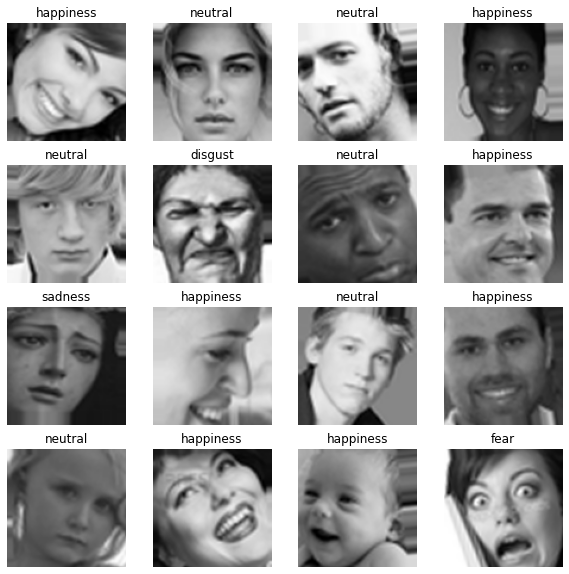

In [13]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [15]:
model = get_base_model(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [16]:
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (ConvLayer)     (None, 100, 100, 64)      2048      
_________________________________________________________________
block1_conv2 (ConvLayer)     (None, 100, 100, 64)      37184     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
block2_conv1 (ConvLayer)     (None, 33, 33, 96)        55776     
_________________________________________________________________
block2_conv2 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
block2_conv3 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 11, 11, 96)        0

# Training

In [17]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [18]:
%%time

epochs = 2

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/2
447/447 [==============================] - 108s 223ms/step - loss: 1.5884 - accuracy: 0.4081 - val_loss: 3.5573 - val_accuracy: 0.2961

Epoch 00001: val_accuracy improved from -inf to 0.29611, saving model to ./modelcheckpoints\FERplus_0325-0933


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus_0325-0933\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus_0325-0933\assets


Epoch 2/2
447/447 [==============================] - 104s 232ms/step - loss: 1.2141 - accuracy: 0.6292 - val_loss: 1.3165 - val_accuracy: 0.5939

Epoch 00002: val_accuracy improved from 0.29611 to 0.59390, saving model to ./modelcheckpoints\FERplus_0325-0933


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus_0325-0933\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus_0325-0933\assets


Wall time: 3min 42s


# Results

## Training Results

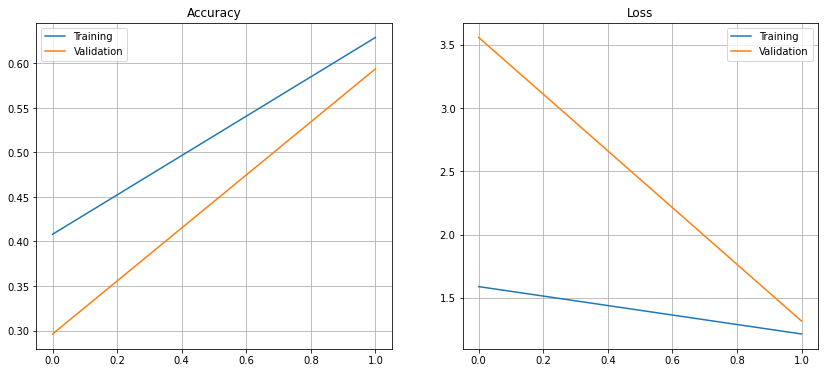

In [19]:
plt.figure(figsize=(14, 6))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [20]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

56/56 - 4s - loss: 1.3039 - accuracy: 0.6091

Accuracy:	60.91%
Loss:		1.3039


# Save Model

In [23]:
save_model = True

if save_model:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    
    # log info about model
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + ":"
    txt += " val=" + str(np.max(history.history['val_accuracy'])*100) + ";"
    txt += " test=" + str(acc*100) + "\n"
    f.write(txt)
    f.close()

---